# Tutorial 9.2: Normalizing Flows on image modeling

**Goal**: show application of NFs on image modeling, assumably on MNIST. Introduce Activation Normalization, 1x1 convolution, multi-scale architecture

In [1]:
USE_NOTEBOOK = True

## Standard libraries
import os
import json
import math
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
if USE_NOTEBOOK:
    %matplotlib inline 
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('svg', 'pdf') # For export
    from matplotlib.colors import to_rgb
    import matplotlib
    matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
if USE_NOTEBOOK:
    from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [2]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
set_seed(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False)

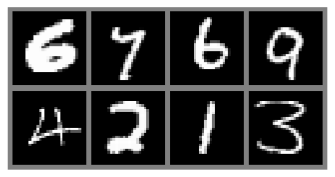

In [3]:
if USE_NOTEBOOK:

    def show_imgs(imgs):
        num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
        nrow = min(num_imgs, 4)
        ncol = int(math.ceil(num_imgs/nrow))
        imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
        np_imgs = imgs.cpu().numpy()
        plt.figure(figsize=(1.5*nrow, 1.5*ncol))
        plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
        plt.axis('off')
        plt.show()
        plt.close()

    show_imgs([train_set[i][0] for i in range(8)])

else:
    def show_imgs(imgs):
        pass

## Flows on images

In [4]:
class ImageFlow(nn.Module):
    
    def __init__(self, flows):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        self.flows = nn.ModuleList(flows)
        
    def forward(self, imgs, return_nll=False):
        z = imgs
        ldj = torch.zeros(z.shape[0], device=device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        if return_nll:
            return nll
        else:
            # Calculating bits per dimension
            bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
            return bpd
        
    def sample(self, img_shape, z_init=None):
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        ldj = torch.zeros(img_shape[0], device=device)
        with torch.no_grad():
            for flow in reversed(self.flows):
                z, ldj = flow(z, ldj, reverse=True)
        return z
        

### Dequantization

In [5]:
class Dequantization(nn.Module):
    
    def __init__(self, alpha=1e-5, quants=256):
        super().__init__()
        self.alpha = alpha
        self.quants = quants 
        
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj
    
    def sigmoid(self, z, ldj, reverse=False):
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj
    
    def dequant(self, z, ldj):
        z = z.to(torch.float32) 
        z = z + torch.rand_like(z)
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

In [6]:
orig_img = train_set[0][0].unsqueeze(dim=0)
ldj = torch.zeros(1,)
dequant_module = Dequantization()
deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)

d1, d2 = torch.where(orig_img.squeeze() != reconst_img.squeeze())
for i in range(d1.shape[0]):
    print("Orig", orig_img[0,0,d1[i], d2[i]])
    print("Reconst", reconst_img[0,0,d1[i], d2[i]])

# Layer is not strictly invertible due to float precision constraints
# assert (orig_img == reconst_img).all().item()

Orig tensor(0, dtype=torch.int32)
Reconst tensor(1, dtype=torch.int32)


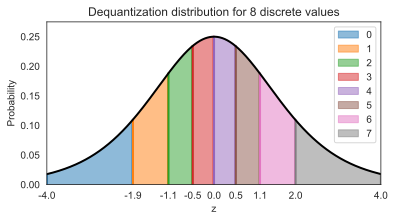

In [7]:
if USE_NOTEBOOK:
    quants = 8
    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1)
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)

    sns.set_style("white")
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    fig = plt.figure(figsize=(6,3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out==v)
        color = to_rgb("C%i"%v)
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color+(0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]]*2,  [0, prob[indices[0][0]]],  color=color)
        plt.plot([inp[indices[0][-1]]]*2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, ["%.1f"%x for x in x_ticks])
    plt.plot(inp,prob, color=(0.0,0.0,0.0))
    
    plt.ylim(0, prob.max()*1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title("Dequantization distribution for %i discrete values" % quants)
    plt.legend()
    plt.show()

In [8]:
class VariationalDequantization(Dequantization):
    
    def __init__(self, var_flows, alpha=1e-5):
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)
        
    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1
        deq_noise = torch.rand_like(z)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

### Coupling layers

In [9]:
class CouplingLayer(nn.Module):
    
    def __init__(self, network, mask, c_in):
        super().__init__()
        self.register_buffer('mask', mask)
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
    
    def forward(self, z, ldj, reverse=False, orig_img=None):
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)
        ## Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        if not reverse:
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])
        return z, ldj

In [10]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y)
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32), 
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

In [11]:
class ConcatELU(nn.Module):
    
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)
    
class LayerNormChannels(nn.Module):
    
    def __init__(self, c_in):
        super().__init__()
        self.layer_norm = nn.LayerNorm(c_in)
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = self.layer_norm(x)
        x = x.permute(0, 3, 1, 2)
        return x

class GatedConv(nn.Module):
    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_hidden, 3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, 1)
        )
    
    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)

class GatedConvNet(nn.Module):
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=4):
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, 3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, 3, padding=1)]
        self.nn = nn.Sequential(*layers)
        
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()
    
    def forward(self, x):
        return self.nn(x)

### Training loop

In [12]:
def train_flow(flow, max_epochs=80, sample_shape=(8,1,28,28), model_name="MNISTFlow"):
    optimizer = optim.Adam(flow.parameters(), lr=1e-3)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98) # Every epoch, we multiply the LR by 0.98
    train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)
    
    print("Start training %s..." % model_name)
    
    avg_bpd = 8.0
    
    val_scores = []
    for epoch in range(max_epochs):
        pbar = tqdm(train_loader, leave=False) if USE_NOTEBOOK else train_loader
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            bpd = flow(imgs).mean()
            bpd.backward()
            nn.utils.clip_grad_norm_(flow.parameters(), 1.0)
            optimizer.step()
            
            avg_bpd = 0.95 * avg_bpd + 0.05 * bpd.item()
            if USE_NOTEBOOK:
                pbar.set_description("[Epoch %i] Bits per dimension: %5.3fbpd" % (epoch+1, avg_bpd))
        lr_scheduler.step()
        if not USE_NOTEBOOK:
            print("Training bpd: %5.3fbpd" % avg_bpd)
        val_bpd = test_flow(flow, val_loader)
        print("[Epoch %2i] Validation bits per dimension: %5.3fbpd" % (epoch+1, val_bpd))
        
        if len(val_scores) == 0 or val_bpd < min(val_scores):
            print("\t   (New best performance, saving model...)")
            save_model(flow, CHECKPOINT_PATH, model_name)
        val_scores.append(val_bpd)
        
        if (epoch+1) % 5 == 0:
            samples = flow.sample(img_shape=sample_shape)
            show_imgs(samples.cpu())
            
    if USE_NOTEBOOK:
        # Plot a curve of the validation accuracy
        sns.set()
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation bits per dimension")
        plt.title("Validation performance of %s" % model_name)
        plt.show()
        plt.close()
    else:
        print("Val scores", val_scores)
    
    test_bpd = test_flow(flow, test_loader)
    print("Test bits per dimension: %5.3fbpd" % (test_bpd))
    
def test_flow(flow, data_loader, import_samples=2):
    flow.eval()
    test_bpd, counter = 0.0, 0
    for imgs, _ in (tqdm(data_loader, leave=False, desc="Testing...") if USE_NOTEBOOK else data_loader):
        imgs = imgs.to(device)
        with torch.no_grad():
            samples = []
            for _ in range(import_samples):
                img_nll = flow(imgs, return_nll=True)
                samples.append(img_nll)
            img_nll = torch.stack(samples, dim=-1)
            img_nll = torch.logsumexp(img_nll, dim=-1) - np.log(import_samples)
            img_bpd = img_nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
            
            test_bpd += img_bpd.sum().item()
            counter += img_bpd.shape[0]
    test_bpd = test_bpd / counter
    return test_bpd 

def save_model(model, model_path, model_name):
    os.makedirs(model_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_path, model_name + ".tar"))

In [13]:
def create_simple_flow(use_vardeq=True):
    set_seed(42)
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]
    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]
    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model
# train_flow(flow_model, model_name=model_name)

## Multi-scale architecture

### Squeeze and Split

In [14]:
class SqueezeFlow(nn.Module):
    
    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse:
            z = z.reshape(B, C, H//2, 2, W//2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4*C, H//2, W//2)
        else:
            z = z.reshape(B, C//4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C//4, H*2, W*2)
        return z, ldj

In [15]:
sq_flow = SqueezeFlow()
rand_img = torch.arange(16).view(1, 1, 4, 4)
print("Image (before)\n", rand_img)
forward_img, _ = sq_flow(rand_img, ldj=None, reverse=False)
print("Image (forward)\n", forward_img)
reconst_img, _ = sq_flow(forward_img, ldj=None, reverse=True)
print("Image (reverse)\n", reconst_img)

Image (before)
 tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])
Image (forward)
 tensor([[[[ 0,  2],
          [ 8, 10]],

         [[ 1,  3],
          [ 9, 11]],

         [[ 4,  6],
          [12, 14]],

         [[ 5,  7],
          [13, 15]]]])
Image (reverse)
 tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])


In [16]:
class SplitFlow(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
    
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
        return z, ldj

### Invertible 1x1 Convolution

In [17]:
class Invertible1x1Conv(nn.Module):
    
    def __init__(self, c_in):
        super().__init__()
        w_init = np.random.randn(c_in, c_in)
        w_init = np.linalg.qr(w_init)[0].astype(np.float32)
        self.weight = nn.Parameter(torch.from_numpy(w_init))
    
    def forward(self, z, ldj, reverse=False):
        weight_ldj = torch.slogdet(self.weight)[1]
        weight_ldj = weight_ldj * z.shape[2] * z.shape[3]
        if not reverse:
            w = self.weight
            ldj += weight_ldj
        else:
            w = torch.inverse(self.weight.double()).float()
            ldj -= weight_ldj
        
        z = F.conv2d(z, w[:,:,None,None])
        return z, ldj

In [18]:
class Invertible1x1ConvLU(nn.Module):
    
    def __init__(self, c_in):
        super().__init__()
        w_init = np.random.randn(c_in, c_in)
        w_init = np.linalg.qr(w_init)[0].astype(np.float32)
        
        # LU decomposition can slightly speed up the inverse
        np_p, np_l, np_u = scipy.linalg.lu(w_init)
        np_s = np.diag(np_u)
        np_sign_s = np.sign(np_s)
        np_log_s = np.log(np.abs(np_s))
        np_u = np.triu(np_u, k=1)
        l_mask = np.tril(np.ones(w_init.shape, dtype=np.float32), -1)
        eye = np.eye(*w_init.shape, dtype=np.float32)

        self.register_buffer('p', torch.Tensor(np_p.astype(np.float32)))
        self.register_buffer('sign_s', torch.Tensor(np_sign_s.astype(np.float32)))
        self.l = nn.Parameter(torch.Tensor(np_l.astype(np.float32)), requires_grad=True)
        self.log_s = nn.Parameter(torch.Tensor(np_log_s.astype(np.float32)), requires_grad=True)
        self.u = nn.Parameter(torch.Tensor(np_u.astype(np.float32)), requires_grad=True)
        self.register_buffer('l_mask', torch.Tensor(l_mask))
        self.register_buffer('eye', torch.Tensor(eye))
    
    def forward(self, z, ldj, reverse=False):
        l, log_s, u = self.l, self.log_s, self.u
        l = l * self.l_mask + self.eye
        u = u * self.l_mask.transpose(0, 1).contiguous() + torch.diag(self.sign_s * torch.exp(log_s))
        w = torch.matmul(self.p, torch.matmul(l, u))
        weight_ldj = log_s.sum()
        weight_ldj = weight_ldj * z.shape[2] * z.shape[3]
        if not reverse:
            ldj += weight_ldj
        else:
            w = torch.inverse(w.double()).float()
            ldj -= weight_ldj
        
        z = F.conv2d(z, w[:,:,None,None])
        return z, ldj

In [19]:
def create_multiscale_flow(use_vardeq=True, use_1x1_convs=True):
    set_seed(42)
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(vardeq_layers)]
    else:
        flow_layers += [Dequantization()]
    
    flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1),
                                  mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                  c_in=1) for i in range(2)]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        if use_1x1_convs:
            flow_layers += [Invertible1x1ConvLU(c_in=4)]
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=4, c_hidden=48),
                                      mask=create_channel_mask(c_in=4, invert=(i%2==1)),
                                      c_in=4)]
    if use_1x1_convs:
        flow_layers += [Invertible1x1ConvLU(c_in=4)]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(4):
        if use_1x1_convs:
            flow_layers += [Invertible1x1ConvLU(c_in=8)]
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=8, c_hidden=64),
                                      mask=create_channel_mask(c_in=8, invert=(i%2==1)),
                                      c_in=8)]


    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model
# train_flow(flow_model, sample_shape=[8,8,7,7], model_name=model_name)

In [20]:
def print_num_params(model):
    num_params = sum([np.prod(p.shape) for p in model.parameters()])
    print("Number of parameters: {:,}".format(num_params))

print_num_params(create_simple_flow(use_vardeq=False))
print_num_params(create_simple_flow(use_vardeq=True))
print_num_params(create_multiscale_flow(use_1x1_convs=False))
print_num_params(create_multiscale_flow(use_1x1_convs=True))

Number of parameters: 442,904
Number of parameters: 665,508
Number of parameters: 1,541,866
Number of parameters: 1,542,518


In [21]:
# train_flow(create_simple_flow(use_vardeq=False), model_name="MNISTFlow_simple")
# train_flow(create_simple_flow(use_vardeq=True), model_name="MNISTFlow_vardeq")
# train_flow(create_multiscale_flow(use_1x1_convs=False), model_name="MNISTFlow_multiscale", sample_shape=[8,8,7,7])
# train_flow(create_multiscale_flow(use_1x1_convs=True), model_name="MNISTFlow_multiscale_1x1_attn", sample_shape=[8,8,7,7])
# train_flow(create_multiscale_flow(use_1x1_convs=True), model_name="MNISTFlow_multiscale_1x1", sample_shape=[8,8,7,7])

## Analysing the flows

### Density modeling and sampling

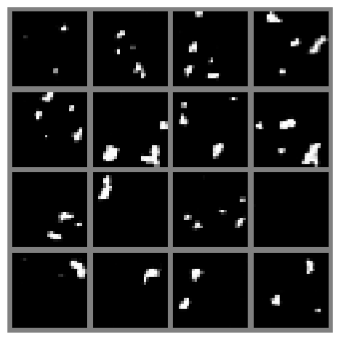

In [22]:
flow_model_simple = create_simple_flow(use_vardeq=True)
flow_model_simple.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "MNISTFlow_vardeq.tar")))
samples = flow_model_simple.sample(img_shape=[16,1,28,28])
show_imgs(samples.cpu())

/home/phillip/anaconda3/envs/nlp1/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)


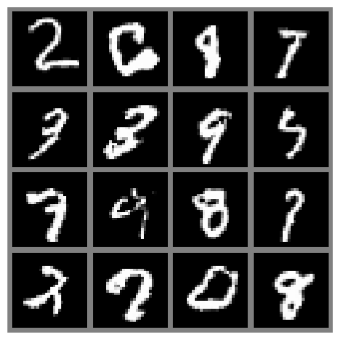

In [23]:
flow_model_multiscale = create_multiscale_flow(use_vardeq=True, use_1x1_convs=True)
flow_model_multiscale.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "MNISTFlow_multiscale_1x1.tar")))
set_seed(42)
samples = flow_model_multiscale.sample(img_shape=[16,8,7,7])
show_imgs(samples.cpu())

Use the following code to generate an overview of the results. The following things should be included:
* Test performance (bpd)
* Time took for testing (seconds)
* Time took for sampling (seconds)
* Number of parameters (million)

In [24]:
if USE_NOTEBOOK:
    from IPython.display import HTML, display
    import tabulate
    table = [["Sun",696000,1989100000],
             ["Earth",6371,5973.6],
             ["Moon",1737,73.5],
             ["Mars",3390,641.85]]
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

Sun,696000,1.9891e+09
Earth,6371,5973.6
Moon,1737,73.5
Mars,3390,641.85


### Interpolation in latent space

Take two training images, and interpolate between their latent space

### Visualization of latents in different levels of multi-scale
Sample from higher level and show how images change or not

In [25]:
multiscale_flow = create_multiscale_flow(use_1x1_convs=True)
multiscale_flow.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "MNISTFlow_multiscale_1x1.tar")))

<All keys matched successfully>

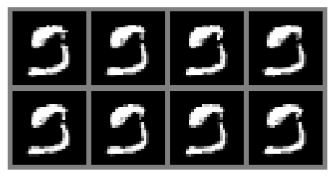

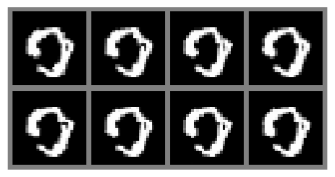

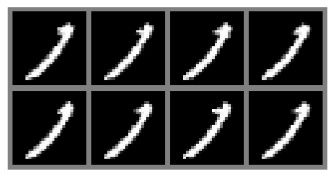

In [26]:
for _ in range(3):
    z_init = multiscale_flow.prior.sample(sample_shape=[1,8,7,7])
    z_init = z_init.expand(8, -1, -1, -1)
    samples = multiscale_flow.sample(img_shape=z_init.shape, z_init=z_init)
    show_imgs(samples.cpu())

### Visualizing Dequantization

In [27]:
dequant_flow = create_simple_flow(use_vardeq=False)
dequant_flow.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "MNISTFlow_simple.tar")))

<All keys matched successfully>

In [28]:
vardeq_flow = create_simple_flow(use_vardeq=True)
vardeq_flow.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "MNISTFlow_vardeq.tar")))

<All keys matched successfully>

In [29]:
if USE_NOTEBOOK:
    def visualize_dequant_distribution(model, imgs):
        imgs = imgs.to(device)
        ldj = torch.zeros(imgs.shape[0], dtype=torch.float32).to(device)
        with torch.no_grad():
            dequant_vals = []
            for _ in range(8):
                d, _ = model.flows[0](imgs, ldj, reverse=False)
                dequant_vals.append(d)
            dequant_vals = torch.cat(dequant_vals, dim=0)
        dequant_vals = dequant_vals.view(-1).cpu().numpy()
        sns.set()
        plt.figure(figsize=(10,3))
        plt.hist(dequant_vals, bins=256, color=to_rgb("C0")+(0.5,), edgecolor="C0", density=True)
        plt.show()
        plt.close()
else:
    def visualize_dequant_distribution(*args, **kwargs):
        pass

In [30]:
sample_imgs, _ = next(iter(train_loader))

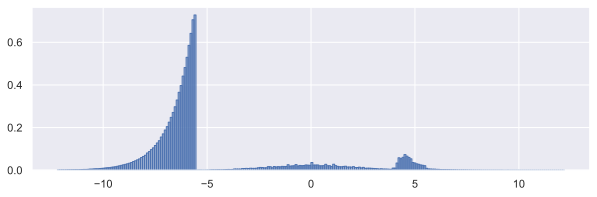

In [31]:
visualize_dequant_distribution(dequant_flow, sample_imgs)

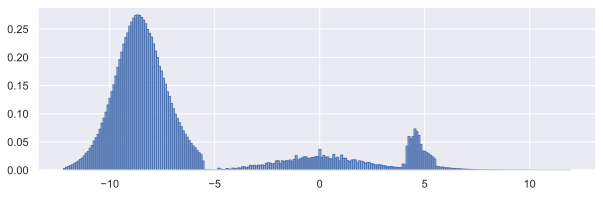

In [32]:
visualize_dequant_distribution(vardeq_flow, sample_imgs)